In [ ]:
!pip install torch torchvision torchaudio
!pip install lightning
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 47.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import torch
import torchvision
import lightning as L
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader,random_split,Subset, SubsetRandomSampler
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchsummary import summary
from tqdm import tqdm
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, Callback
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-know-what-you-did-last-measurement-time

# Unzip the downloaded files and then remove the zip files
!unzip bgu-i-know-what-you-did-last-measurement-time.zip

Streaming output truncated to the last 5000 lines.
  inflating: unlabeled/unlabeled/95499.csv  
  inflating: unlabeled/unlabeled/955.csv  
  inflating: unlabeled/unlabeled/9550.csv  
  inflating: unlabeled/unlabeled/95500.csv  
  inflating: unlabeled/unlabeled/95501.csv  
  inflating: unlabeled/unlabeled/95502.csv  
  inflating: unlabeled/unlabeled/95503.csv  
  inflating: unlabeled/unlabeled/95504.csv  
  inflating: unlabeled/unlabeled/95505.csv  
  inflating: unlabeled/unlabeled/95506.csv  
  inflating: unlabeled/unlabeled/95507.csv  
  inflating: unlabeled/unlabeled/95508.csv  
  inflating: unlabeled/unlabeled/95509.csv  
  inflating: unlabeled/unlabeled/9551.csv  
  inflating: unlabeled/unlabeled/95510.csv  
  inflating: unlabeled/unlabeled/95511.csv  
  inflating: unlabeled/unlabeled/95512.csv  
  inflating: unlabeled/unlabeled/95513.csv  
  inflating: unlabeled/unlabeled/95514.csv  
  inflating: unlabeled/unlabeled/95515.csv  
  inflating: unlabeled/unlabeled/95516.csv  
  inflat

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
unlabeled_dir = '/content/unlabeled/unlabeled'

unlabeled_files = os.listdir(unlabeled_dir)

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'activity' column to get encoded labels
train_data['activity_encoded'] = label_encoder.fit_transform(train_data['activity'])

In [ ]:
train_data.head()

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length,activity_encoded
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000,5
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000,12
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000,12
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000,9
4,4,user07,using_phone,vicon,hand,left,61641,4000,7


In [ ]:
# Create a copy of train_data
encoded_train_data = train_data.copy()

# One-hot encode categorical features on the copied DataFrame and drop the first to avoid multicollinearity
encoded_train_data = pd.get_dummies(encoded_train_data, columns=['sensor', 'body_part', 'side'], drop_first=True)

In [ ]:
encoded_train_data.head()

,Unnamed: 0,userid,activity,id,sequence_length,activity_encoded,sensor_vicon,body_part_hand,side_right
0,0,user01,stairs_up,3387,3000,5,0,1,1
1,1,user01,walking_with_hands_in_pockets,8473,4000,12,0,1,0
2,2,user08,walking_with_hands_in_pockets,74365,3000,12,0,1,1
3,3,user01,walking_freely,6223,3000,9,0,1,1
4,4,user07,using_phone,61641,4000,7,1,1,0


**a. validation strategy - train_test_split**

In [ ]:
from sklearn.model_selection import train_test_split

# Identify unique users
unique_subjects = train_data['userid'].unique()

# Split user IDs into training and validation sets
train_subjects, val_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Create training and validation sets
train_set = train_data[train_data['userid'].isin(train_subjects)]
val_set = train_data[train_data['userid'].isin(val_subjects)]

# Summary of the split
print(f"Training set includes {len(train_set)} samples from {len(train_subjects)} subjects.")
print(f"Validation set includes {len(val_set)} samples from {len(val_subjects)} subjects.")

Training set includes 38001 samples from 6 subjects.
Validation set includes 12247 samples from 2 subjects.


**Extract Statistical Features**

In [ ]:
import os
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_statistical_features(df, data_dir):
    """
    Extracts statistical features from time-series data corresponding to each row in the DataFrame.

    Parameters:
    - df: DataFrame with at least an 'id' column to locate the data files.
    - data_dir: The directory where the sequence data files are stored.

    Returns:
    - DataFrame with original data augmented with statistical features.
    """
    df = df.copy()

    means, stds, mins, maxs, medians, skews, kurtoses = [], [], [], [], [], [], []

    for _, row in df.iterrows():
        seq_id = row['id']
        file_path = os.path.join(data_dir, f"{seq_id}.csv")
        seq_df = pd.read_csv(file_path)

        # Filter by measurement type if necessary
        if "measurement type" in seq_df.columns:
            seq_df = seq_df[seq_df["measurement type"] == "acceleration [m/s/s]"]

        # Calculate statistical features for each axis
        for axis in ['x', 'y', 'z']:
            axis_data = seq_df[axis] if axis in seq_df.columns else seq_df[f"{axis} [m]"]
            means.append(axis_data.mean())
            stds.append(axis_data.std())
            mins.append(axis_data.min())
            maxs.append(axis_data.max())
            medians.append(axis_data.median())
            skews.append(skew(axis_data))  # Corrected
            kurtoses.append(kurtosis(axis_data))  # Corrected

    # Create a DataFrame with the calculated features
    features_df = pd.DataFrame({
        'x_mean': means[0::3], 'y_mean': means[1::3], 'z_mean': means[2::3],
        'x_std': stds[0::3], 'y_std': stds[1::3], 'z_std': stds[2::3],
        'x_min': mins[0::3], 'y_min': mins[1::3], 'z_min': mins[2::3],
        'x_max': maxs[0::3], 'y_max': maxs[1::3], 'z_max': maxs[2::3],
        'x_median': medians[0::3], 'y_median': medians[1::3], 'z_median': medians[2::3],
        'x_skew': skews[0::3], 'y_skew': skews[1::3], 'z_skew': skews[2::3],
        'x_kurtosis': kurtoses[0::3], 'y_kurtosis': kurtoses[1::3], 'z_kurtosis': kurtoses[2::3],
    })

    # Return the original DataFrame augmented with the new features
    return pd.concat([df.reset_index(drop=True), features_df], axis=1)

In [ ]:
train_features = extract_statistical_features(train_set, unlabeled_dir)
val_features = extract_statistical_features(val_set, unlabeled_dir)

In [ ]:
# Specify the paths where you want to save the CSV files
train_features_path = '/content/drive/My Drive/DLW_Dataset/train_features_2.csv'
val_features_path = '/content/drive/My Drive/DLW_Dataset/val_features_2.csv'

# Save the train_features DataFrame as a CSV file
train_features.to_csv(train_features_path, index=False)

# Save the val_features DataFrame as a CSV file
val_features.to_csv(val_features_path, index=False)

In [ ]:
# Create directory if it does not exist
os.makedirs(os.path.dirname(train_features_path), exist_ok=True)
os.makedirs(os.path.dirname(val_features_path), exist_ok=True)

In [ ]:
# Load the train_features DataFrame from the saved CSV file
train_features_loaded = pd.read_csv('/content/train_features_1.csv')

# Load the val_features DataFrame from the saved CSV file
val_features_loaded = pd.read_csv('/content/val_features_1.csv')


In [ ]:
features_columns = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std','x_min', 'y_min', 'z_min','x_max', 'y_max', 'z_max','x_median', 'y_median', 'z_median', 'x_skew', 'y_skew', 'z_skew','x_kurtosis', 'y_kurtosis', 'z_kurtosis']

In [ ]:
# Assuming 'features_columns' is a list of your feature column names
X_train_loaded = train_features_loaded[features_columns].values
X_val_loaded = val_features_loaded[features_columns].values

y_train_loaded = train_features_loaded['activity_encoded'].values
y_val_loaded = val_features_loaded['activity_encoded'].values

**d. 1D- CNN Models**

In [ ]:
class HARDataset(Dataset):
    def __init__(self, data, data_dir, transform=None, labeled=True):
        """
        Initializes the dataset.
        :param data: DataFrame for labeled data or list of filenames for unlabeled data.
        :param data_dir: Base directory where the data files are stored.
        :param transform: Optional transform to be applied on a sample.
        :param labeled: Flag indicating if the dataset is for labeled or unlabeled data.
        """
        self.data = data
        self.data_dir = data_dir
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labeled:
            # Handling labeled data
            seq_id, activity_label = self.data.iloc[idx]['id'], self.data.iloc[idx]['activity_encoded']
            seq_file_path = os.path.join(self.data_dir, f"{seq_id}.csv")
        else:# Handling unlabeled data
            seq_file_path = os.path.join(self.data_dir, self.data[idx])

        # Load sequence data
        seq_frame = pd.read_csv(seq_file_path)
        if self.labeled and "measurement type" in seq_frame.columns:
            # Filter by acceleration if it's labeled data and contains a 'measurement type' column
            seq_frame = seq_frame[seq_frame["measurement type"] == "acceleration [m/s/s]"]
            sequence_data = seq_frame.iloc[:, 1:4].values
        else:
            sequence_data = seq_frame.values  # Use all data if no filtering criteria

        # Apply transformations
        if self.transform:
            sequence_data = self.transform(sequence_data)
        sequence_data_tensor = torch.tensor(sequence_data, dtype=torch.float32)

        if self.labeled:
            activity_label = self.data.iloc[idx]['activity_encoded']
            activity_label_tensor = torch.tensor(activity_label, dtype=torch.long)
            return sequence_data_tensor, activity_label_tensor
        else:
            return sequence_data_tensor  # No label for unlabeled data

In [ ]:
# Padding on both sides for CNN
def fixed_padding(batch):
    max_length = 3000
    # Determine if labels are included
    labels_present = len(batch[0]) == 2

    # Initialize padded sequences
    padded_sequences = torch.zeros(len(batch), max_length, batch[0][0].shape[1])
    labels = []

    for i, item in enumerate(batch):
        sequence = item[0]
        label = item[1] if labels_present else None
        length = sequence.shape[0]

        # Calculate padding for both sides
        padding_left = (max_length - length) // 2
        padding_right = max_length - length - padding_left

        # Apply padding
        if length >= max_length:
            padded_sequences[i, :] = sequence[:max_length]
        else:
            padded_sequences[i, padding_left:length+padding_left, :] = sequence

        # Collect labels if present
        if labels_present:
            labels.append(label)

    # Stack labels if they are present, else return None for labels
    labels_tensor = torch.stack(labels) if labels_present else None

    # Return based on whether labels are present
    return (padded_sequences, labels_tensor) if labels_present else padded_sequences


**# 1D - CNN**

In [ ]:
class CNN1DModle(L.LightningModule):
    def __init__(self, num_features, num_classes=18, max_length=3000, dropout=0.4):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout1 = nn.Dropout(dropout)  # Dropout layer after convolutions
        # Calculate the resulting sequence length after convolutions and pooling
        conv_output_size = max_length // (2**3)  # Assuming 3 pooling layers
        self.fc1 = nn.Linear(64 * conv_output_size, 128)
        self.dropout2 = nn.Dropout(dropout)  # Dropout before the final layer
        self.fc2 = nn.Linear(128, num_classes)


        # save all the metrics
        self.TrainLossEs = []
        self.ValLossEs = []
        self.TrainAcc = []
        self.ValAcc = []


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)  # Apply dropout after last pooling layer
        x = torch.flatten(x, 1)  # Flatten the tensor for the dense layer
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        outputs = self(sequences)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.mean((preds == labels).float())
        self.TrainLossEs.append(loss.item())
        self.TrainAcc.append(acc.item())
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        outputs = self(sequences)
        loss = F.cross_entropy(outputs, labels)
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = torch.mean((preds == labels).float())
        self.ValLossEs.append(loss.item())
        self.ValAcc.append(acc.item())
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def get_train_loss(self):
        return self.TrainLossEs

    def get_val_loss(self):
        return self.ValLossEs

    def get_train_acc(self):
        return self.TrainAcc

    def get_val_acc(self):
        return self.ValAcc

In [ ]:
# Create dataset instances
train_dataset = HARDataset(train_features_loaded, unlabeled_dir, labeled=True)
val_dataset = HARDataset(val_features_loaded, unlabeled_dir, labeled=True)

In [ ]:
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=fixed_padding)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=fixed_padding)

In [ ]:
# sample 30% of the data from each set
subset_train_size = int(len(train_set) * 0.5)
subset_val_size = int(len(val_set) * 0.5)

train_subset_df = train_features_loaded.sample(n=subset_train_size, random_state=42)
val_subset_df = val_features_loaded.sample(n=subset_val_size, random_state=42)

# Create dataset instances using the subset DataFrames
train_dataset_subset = HARDataset(train_subset_df, unlabeled_dir, labeled=True)
val_dataset_subset = HARDataset(val_subset_df, unlabeled_dir, labeled=True)

# Create data loaders using the subset datasets
train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=64, shuffle=True, collate_fn=fixed_padding)
val_dataloader_subset = DataLoader(val_dataset_subset, batch_size=64, shuffle=False, collate_fn=fixed_padding)

In [ ]:
for i, (x, y) in enumerate(train_dataloader):
    if i == 5:
        break
    print(f"Batch {i+1}:")
    print(f"X shape: {x.shape}")
    print(f"y shape: {y.shape}")
    print(f"y: {y}")
    print()

Batch 1:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([16,  9, 10,  8,  9, 10, 12,  4,  0, 10, 10, 10,  1,  0,  5,  2,  5, 13,
         7,  1, 10, 16,  7, 13, 10,  3, 11,  1, 13, 15, 11,  7,  6,  1,  3,  8,
         3, 14, 14, 15, 11,  2,  9, 10,  3,  5,  9,  8,  3, 14,  8,  8,  9,  4,
        16, 11, 13, 10, 11,  4,  7,  3, 14, 10])

Batch 2:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([10,  7, 13,  3,  3,  1, 11, 15,  3,  8, 13,  1,  1, 11,  5, 13,  2, 12,
        15, 17, 14, 12, 11, 11, 10,  9,  9, 13, 16,  2,  4, 10, 10, 12, 15,  3,
        13, 16, 11, 10,  9, 13,  5,  5, 14, 10,  3,  6, 10,  7, 13, 10,  0,  9,
        15,  9,  0, 14,  2, 13, 16,  5,  0,  5])

Batch 3:
X shape: torch.Size([64, 3000, 3])
y shape: torch.Size([64])
y: tensor([13,  0, 12,  2,  9,  5, 13,  9, 14,  8,  7, 10, 12, 13, 11, 14,  6, 10,
         1,  9, 13, 11, 14, 15, 11,  7, 10, 14,  7, 14, 11,  2, 17,  7,  3,  2,
        10,  6, 10,  9,  9,  0,  9, 12, 1

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

def train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=20, patience=5):

    # Logging
    logger = TensorBoardLogger("lightning_logs", name="CNN Models")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        monitor='val_loss',  # Save the model based on the validation loss
        filename='CNN1D-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,  # Save the best model only
        mode='min',  # Minimize validation loss
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        mode='max',
    )

    # Trainer
    trainer = L.Trainer(
        default_root_dir='checkpoints/',
        log_every_n_steps=5,
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        callbacks=[model_checkpoint, early_stopping],
        logger=logger
    )

    # Assuming 'trainer' is already defined and initialized
    if hasattr(trainer, 'logger') and trainer.logger:
        trainer.logger._log_graph = True  # This will log the model graph for visualization in TensorBoard
        trainer.logger._default_hp_metric = None  # This will disable the default hyperparameter metric logging

    # Start training
    trainer.fit(model, train_dataloader, val_dataloader)

    # Retrieve metrics from the trainer's logged metrics
    train_loss = trainer.logged_metrics.get('train_loss')
    val_loss = trainer.logged_metrics.get('val_loss')
    train_acc = trainer.logged_metrics.get('train_accuracy')
    val_acc = trainer.logged_metrics.get('val_accuracy')

    metrics = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
    }

    return model, metrics

In [ ]:
def epoch_array(matric_batch_array, num_epoch):
  """
  The  function calculates the mean matric value fo each epoch
  """
  res = []
  for i in np.array_split(matric_batch_array,num_epoch):
    res.append(float(np.mean(i)))
  return res

In [ ]:
def plot_acc_and_loss(model, num_epoch):
  """
  Helper function to plot the graphs
  """

  train_losses = epoch_array(model.get_train_loss(), num_epoch)
  val_losses = epoch_array(model.get_val_loss(), num_epoch)
  train_accs = epoch_array(model.get_train_acc(), num_epoch)
  val_accs = epoch_array(model.get_val_acc(), num_epoch)

  epochs = range(1, num_epoch + 1)

  # Plot training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_losses, '.-', label='Training Loss', color = '#609d9e')
  plt.plot(epochs, val_losses, '.-', label='Validation Loss', color = '#075052')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot training and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_accs, '.-', label='Training Accuracy', color = '#609d9e')
  plt.plot(epochs, val_accs, '.-', label='Validation Accuracy', color = '#075052')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# 1D-CNN Model
model = CNN1DModle(num_features=3, num_classes=18, max_length=3000)
model, metrics =  train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=15, patience=5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv1d    | 160   
1 | conv2    | Conv1d    | 1.6 K 
2 | conv3    | Conv1d    | 6.2 K 
3 | pool     | MaxPool1d | 0     
4 | dropout1 | Dropout   | 0     
5 | fc1      | Linear    | 3.1 M 
6 | dropout2 | Dropout   | 0     
7 | fc2      | Linear    | 2.3 K 
----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


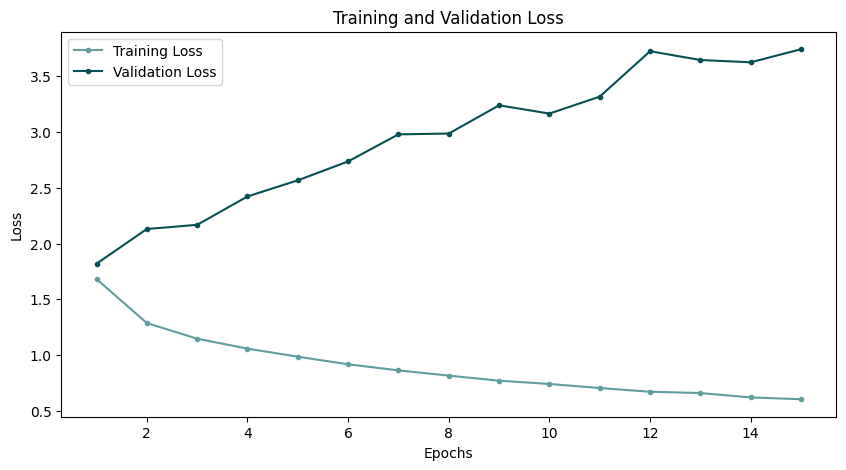

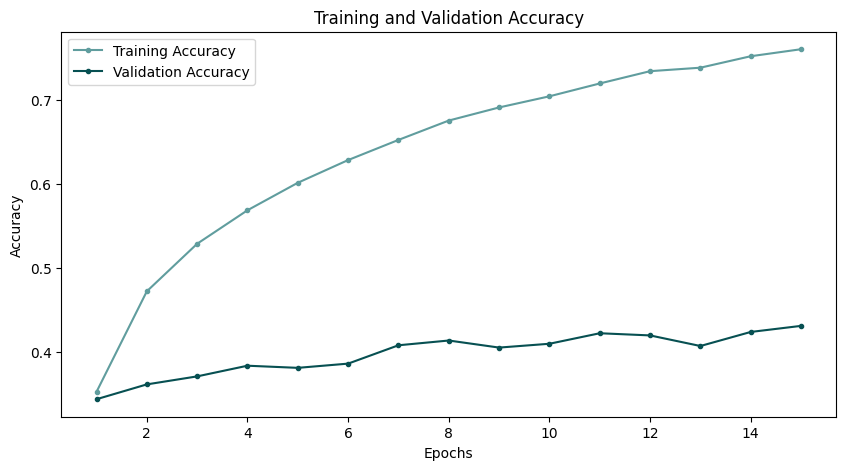

In [ ]:
epochs = 15
plot_acc_and_loss(model, epochs)

In [ ]:
def extract_predictions(model, dataloader):
    model.eval()
    model.freeze()
    predictions, labels, probabilities = [], [], []
    with torch.no_grad():
        for sequences, labels_batch in dataloader:
            outputs = model(sequences)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    return predictions, labels, probabilities

# Extract predictions and probabilities from the validation set
predictions, true_labels, probabilities = extract_predictions(model, val_dataloader)

In [ ]:
def visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5):
    # Convert numerical labels back to original activity names
    predicted_activities = label_encoder.inverse_transform(predictions)
    true_activities = label_encoder.inverse_transform(true_labels)

    # Prepare data for DataFrame
    data = []
    good_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred == true][:num_examples]
    for i in good_indices:
        data.append({
            'Index': i,
            'Type': 'Good',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    bad_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true][:num_examples]
    for i in bad_indices:
        data.append({
            'Index': i,
            'Type': 'Bad',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    uncertain_indices = sorted(range(len(probabilities)), key=lambda i: max(probabilities[i]))[:num_examples]
    for i in uncertain_indices:
        data.append({
            'Index': i,
            'Type': 'Uncertain',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    # Create and return DataFrame
    results_df = pd.DataFrame(data)

    # Round the 'Probability' column to 4 decimal places
    results_df['Probability'] = results_df['Probability'].round(4)

    return results_df

In [ ]:
visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5)

,Index,Type,Predicted,True,Probability
0,0,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,1.0000
1,1,Good,reading_book,reading_book,0.9627
2,3,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,1.0000
3,4,Good,using_phone,using_phone,1.0000
4,5,Good,using_phone,using_phone,1.0000
5,2,Bad,using_phone,walking_with_object_underarm,0.4481
6,6,Bad,walking_with_object_underarm,using_phone,0.3612
7,8,Bad,using_remote_control,reading_book,0.5018
8,9,Bad,walking_with_handbag,walking_with_object_underarm,0.7911
9,11,Bad,typing,writing,0.5069


### **Improved 1D-CNN Model**

In [ ]:
import torch.nn.functional as F

class ImprovedCNN1DModel(L.LightningModule):
    def __init__(self, num_features, num_classes=18, max_length=3000, dropout_rate=0.5):
        super().__init__()
        self.save_hyperparameters()

        # Increased depth with more convolutional layers and added batch normalization
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2, 2)

        # Apply dropout for regularization
        self.dropout1 = nn.Dropout(dropout_rate)

        # Adjusted fully connected layers for added depth
        conv_output_size = max_length // (2**4)  # Adjust for four pooling layers
        self.fc1 = nn.Linear(256 * conv_output_size, 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, num_classes)

        # save all the metrics
        self.TrainLossEs = []
        self.ValLossEs = []
        self.TrainAcc = []
        self.ValAcc = []

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjust for Conv1d input
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout1(x)  # Apply dropout after last pooling layer
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        outputs = self(sequences)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.mean((preds == labels).float())
        self.TrainLossEs.append(loss.item())
        self.TrainAcc.append(acc.item())
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        outputs = self(sequences)
        loss = F.cross_entropy(outputs, labels)
        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = torch.mean((preds == labels).float())
        self.ValLossEs.append(loss.item())
        self.ValAcc.append(acc.item())
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0005)

    def get_train_loss(self):
        return self.TrainLossEs

    def get_val_loss(self):
        return self.ValLossEs

    def get_train_acc(self):
        return self.TrainAcc

    def get_val_acc(self):
        return self.ValAcc

In [ ]:
# Create dataset instances
train_dataset = HARDataset(train_features_loaded, unlabeled_dir, labeled=True)
val_dataset = HARDataset(val_features_loaded, unlabeled_dir, labeled=True)

In [ ]:
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=fixed_padding)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=fixed_padding)

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

def train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=10, patience=5):

    # Logging
    logger = TensorBoardLogger("lightning_logs", name="ImprovedCNN1DMode")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        monitor='val_loss',  # Save the model based on the validation loss
        filename='ImprovedCNN1DMode-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,  # Save the best model only
        mode='min',  # Minimize validation loss
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        mode='max',
    )

    # Trainer
    trainer = L.Trainer(
        default_root_dir='checkpoints/',
        log_every_n_steps=5,
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        callbacks=[model_checkpoint, early_stopping],
        logger=logger
    )

    # Assuming 'trainer' is already defined and initialized
    if hasattr(trainer, 'logger') and trainer.logger:
        trainer.logger._log_graph = True  # This will log the model graph for visualization in TensorBoard
        trainer.logger._default_hp_metric = None  # This will disable the default hyperparameter metric logging

    # Model
    # model = CNN1DModle(num_features=3, num_classes=18, max_length=4000)

    # Start training
    trainer.fit(model, train_dataloader, val_dataloader)

    # Retrieve metrics from the trainer's logged metrics
    train_loss = trainer.logged_metrics.get('train_loss')
    val_loss = trainer.logged_metrics.get('val_loss')
    train_acc = trainer.logged_metrics.get('train_accuracy')
    val_acc = trainer.logged_metrics.get('val_accuracy')

    metrics = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
    }

    return model, metrics

In [ ]:
def epoch_array(matric_batch_array, num_epoch):
  """
  The  function calculates the mean matric value fo each epoch
  """
  res = []
  for i in np.array_split(matric_batch_array,num_epoch):
    res.append(float(np.mean(i)))
  return res

In [ ]:
def plot_acc_and_loss(model, num_epoch):
  """
  Helper function to plot the graphs
  """

  train_losses = epoch_array(model.get_train_loss(), num_epoch)
  val_losses = epoch_array(model.get_val_loss(), num_epoch)
  train_accs = epoch_array(model.get_train_acc(), num_epoch)
  val_accs = epoch_array(model.get_val_acc(), num_epoch)

  epochs = range(1, num_epoch + 1)

  # Plot training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_losses, '.-', label='Training Loss', color = '#609d9e')
  plt.plot(epochs, val_losses, '.-', label='Validation Loss', color = '#075052')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot training and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_accs, '.-', label='Training Accuracy', color = '#609d9e')
  plt.plot(epochs, val_accs, '.-', label='Validation Accuracy', color = '#075052')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# ImprovedCNN1DModel
model = ImprovedCNN1DModel(num_features=3, num_classes=18, max_length=3000)
model, metrics = train_and_evaluate(model, train_dataloader, val_dataloader, max_epochs=10, patience=5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv1d      | 320   
1  | bn1      | BatchNorm1d | 64    
2  | conv2    | Conv1d      | 6.2 K 
3  | bn2      | BatchNorm1d | 128   
4  | conv3    | Conv1d      | 24.7 K
5  | bn3      | BatchNorm1d | 256   
6  | conv4    | Conv1d      | 98.6 K
7  | bn4      | BatchNo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


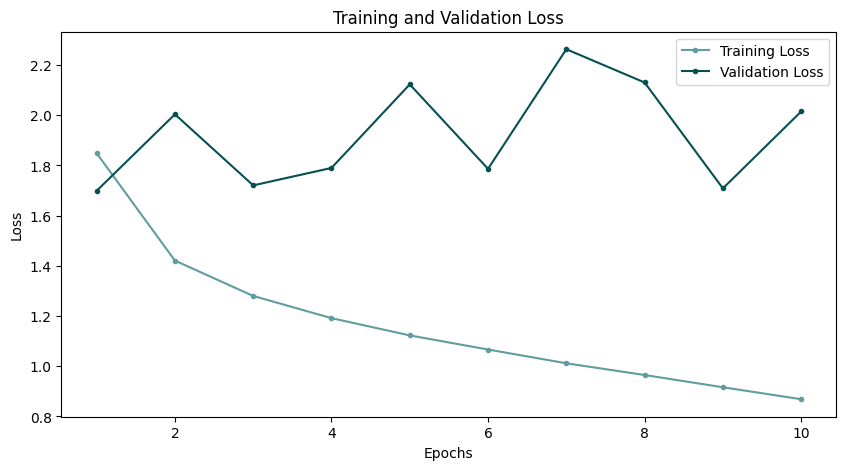

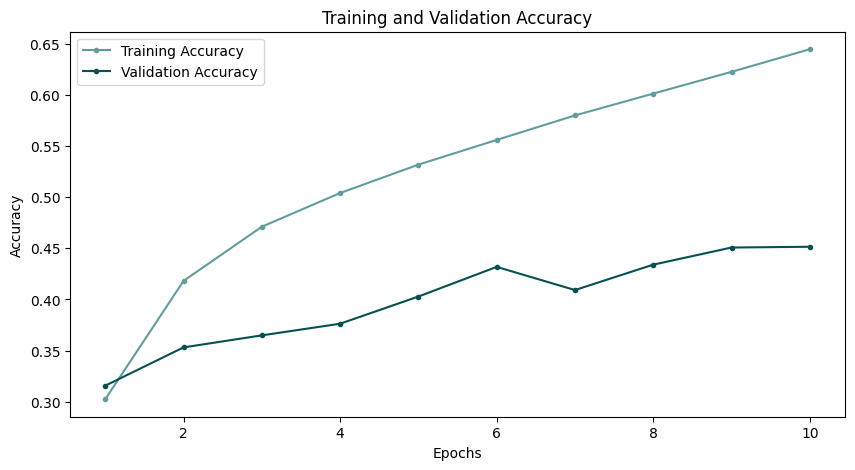

In [ ]:
epochs = 10
plot_acc_and_loss(model, epochs)

In [ ]:
def extract_predictions(model, dataloader):
    model.eval()
    model.freeze()
    predictions, labels, probabilities = [], [], []
    with torch.no_grad():
        for sequences, labels_batch in dataloader:
            outputs = model(sequences)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    return predictions, labels, probabilities

# Extract predictions and probabilities from the validation set
predictions, true_labels, probabilities = extract_predictions(model, val_dataloader)

In [ ]:
def visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5):
    # Convert numerical labels back to original activity names
    predicted_activities = label_encoder.inverse_transform(predictions)
    true_activities = label_encoder.inverse_transform(true_labels)

    # Prepare data for DataFrame
    data = []
    good_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred == true][:num_examples]
    for i in good_indices:
        data.append({
            'Index': i,
            'Type': 'Good',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    bad_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true][:num_examples]
    for i in bad_indices:
        data.append({
            'Index': i,
            'Type': 'Bad',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    uncertain_indices = sorted(range(len(probabilities)), key=lambda i: max(probabilities[i]))[:num_examples]
    for i in uncertain_indices:
        data.append({
            'Index': i,
            'Type': 'Uncertain',
            'Predicted': predicted_activities[i],
            'True': true_activities[i],
            'Probability': max(probabilities[i])
        })

    # Create and return DataFrame
    results_df = pd.DataFrame(data)

    # Round the 'Probability' column to 4 decimal places
    results_df['Probability'] = results_df['Probability'].round(4)

    return results_df

In [ ]:
visualize_classifications_df(predictions, true_labels, probabilities, label_encoder, num_examples=5)

,Index,Type,Predicted,True,Probability
0,0,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,1.0000
1,1,Good,reading_book,reading_book,0.8821
2,3,Good,walking_with_hands_in_pockets,walking_with_hands_in_pockets,1.0000
3,4,Good,using_phone,using_phone,1.0000
4,5,Good,using_phone,using_phone,1.0000
5,2,Bad,walking_freely,walking_with_object_underarm,0.3473
6,6,Bad,idle,using_phone,0.1693
7,7,Bad,walking_with_object_underarm,walking_holding_a_tray,0.2026
8,8,Bad,using_remote_control,reading_book,0.4503
9,9,Bad,walking_freely,walking_with_object_underarm,0.3039
